# Optional Lab - Multi-class Classification


## 1.1 Goals
In this lab, you will explore an example of multi-class classification using neural networks.

## 1.2 Tools
You will use some plotting routines. These are stored in `lab_utils_multiclass_TF.py` in this directory.

In [1]:
!pip install ipympl  # it's not a defaultly installed package in google colab, therefore, let's install itm

In [2]:
from google.colab import output
output.enable_custom_widget_manager()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from sklearn.datasets import make_blobs

import torch
from torch import nn

np.set_printoptions(precision=2)
from lab_utils_multiclass_TF import *  # import for plotting, TF is not used there


# 2.0 Multi-class Classification
Neural Networks are often used to classify data. Examples are neural networks:
- take in photos and classify subjects in the photos as {dog,cat,horse,other}
- take in a sentence and classify the 'parts of speech' of its elements: {noun, verb, adjective etc..}  

A network of this type will have multiple units in its final layer. Each output is associated with a category. When an input example is applied to the network, the output with the highest value is the category predicted. If the output is applied to a softmax function, the output of the softmax will provide probabilities of the input being in each category.

In this lab you will see an example of building a multiclass network in Tensorflow. We will then take a look at how the neural network makes its predictions.

Let's start by creating a four-class data set.

## 2.1 Prepare and visualize our data
We will use Scikit-Learn `make_blobs` function to make a training data set with 4 categories as shown in the plot below.

In [4]:
# make 4-class dataset for classification
classes = 4
m = 100
centers = [[-5, 2], [-2, -2], [1, 2], [5, -2]]
std = 1.0
X_train, y_train = make_blobs(n_samples=m, centers=centers, cluster_std=std,random_state=30)


/content/lab_utils_multiclass_TF.py:63: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(X[idx, 0], X[idx, 1],  marker=m,


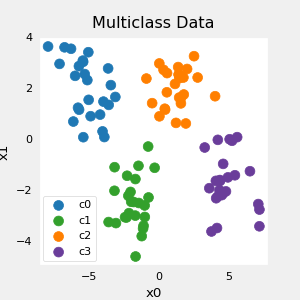

In [5]:
plt_mc(X_train,y_train,classes, centers, std=std)


Each dot represents a training example. The axis (x0,x1) are the inputs and the color represents the class the example is associated with. Once trained, the model will be presented with a new example, (x0,x1), and will predict the class.  

While generated, this data set is representative of many real-world classification problems. There are several input features (x0,...,xn) and several output categories. The model is trained to use the input features to predict the correct output category.

In [6]:
# convert X and y into tensors, otherwise problems with data dimensions
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()

In [7]:
# show classes in data set
print(f"unique classes {np.unique(y_train)}")
# show how classes are represented
print(f"class representation {y_train[:10]}")
# show shapes of our dataset
print(f"shape of X_train: {X_train.shape}, shape of y_train: {y_train.shape}")

unique classes [0 1 2 3]
class representation tensor([3, 3, 3, 0, 3, 3, 3, 3, 2, 0])
shape of X_train: torch.Size([100, 2]), shape of y_train: torch.Size([100])


## 2.2 Model
This lab will use a 2-layer network as shown.
Unlike the binary classification networks, this network has four outputs, one for each class. Given an input example, the output with the highest value is the predicted class of the input.   

Below is an example of how to construct this network in *PyTorch*.


*There are two equally legit ways of implementing multiclass classification with CrossEntropy: either with the linear layer as the last activation layer and CrossEntropyLoss as a criterion (aka loss function); or with LogSoftmax layer as the last activation layer and NNNLoss criterion. The former applies log-softmax internally. [Explanation from the forum](https://discuss.pytorch.org/t/difference-between-cross-entropy-loss-or-log-likelihood-loss/38816), [Cheetsheet](https://github.com/rasbt/stat479-deep-learning-ss19/blob/master/other/pytorch-lossfunc-cheatsheet.md).*

*Here, I am using the linear layer as an activation function and CrossEntropyLoss.*


In [8]:
class MulticlassClassifier(nn.Module):
  def __init__(self):
    super(MulticlassClassifier, self).__init__()

    self.training_accuracy = []
    self.training_loss = []

    self.linear1 = nn.Linear(in_features=2, out_features=2)
    self.relu1 = nn.ReLU()
    self.linear2 = nn.Linear(in_features=2, out_features=4)

  def forward(self, x):
    layer1_output = self.relu1(self.linear1(x))
    layer2_output = self.linear2(layer1_output)
    return layer2_output

  def predict(self, x: np.array) -> np.array:
    '''
    Predict a label for each datapoint in x.
    Since this function is needed for plotting later (in plt_cat_md) and the plotting
    function passes to predict() a numpy array, I internally convert it to a tensor
    and then convert back to a numpy array.
    '''
    self.eval()  # set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for inference
      logits = self.forward(torch.from_numpy(x).float())
    _, label = torch.max(logits, dim=1)
    return label.numpy()

*Let's initiate the loss function and optimizer for our classifier.*



In [9]:
loss_fn = nn.CrossEntropyLoss()
classifier = MulticlassClassifier()

# move the model to GPU if we have one
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier.to(device)

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.01)

BATCH_SIZE = 32


*Let's define a custom Dataset class to be able to use Dataloader class from PyTorch for easy access to the data in batches*

In [10]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [11]:
train_dataset = CustomDataset(X_train, y_train)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True  # Reshuffle the data at every epoch to reduce model overfitting
)

In [12]:
from tqdm import tqdm  # for printing ETA


def train_one_epoch(epoch):
    classifier.train(True)

    # create wrapper around train_dataloader in order to see the progress in batches
    with tqdm(train_loader, total=len(X_train)//BATCH_SIZE+1, unit="batch", desc=f'Epoch {epoch+1}') as batches:
        for batch in batches:
          # unpack each batch into X and y
          inputs, labels = batch
          if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

          # Zero your gradients for every batch!
          optimizer.zero_grad()

          # Make predictions for this batch -- calling forward() internally
          outputs = classifier(inputs)

          # Compute the loss and its gradients
          loss = loss_fn(outputs, labels)
          loss.backward()

          # Adjust learning weights
          optimizer.step()

          # outputs.argmax picks one label with the highest value of logits and assigns it to the datapoint
          accuracy = (outputs.argmax(dim=1) == labels).float().mean().item() * 100

          classifier.training_accuracy.append(accuracy)
          classifier.training_loss.append(loss.item())

          batches.set_postfix(loss=loss.item(), accuracy=f'{accuracy}%')                  # Update the progress bar


In [13]:
EPOCHS = 200  # the same number as in the original lab
for epoch in range(EPOCHS):
    train_one_epoch(epoch)

Epoch 200: 100%|██████████| 4/4 [00:00<00:00, 33.05batch/s, accuracy=100.0%, loss=0.0309]


*Let's plot the loss vs accuracy in order to track changes in the training. Since we have 200 epochs, it's easier to see the changes on a graph.*

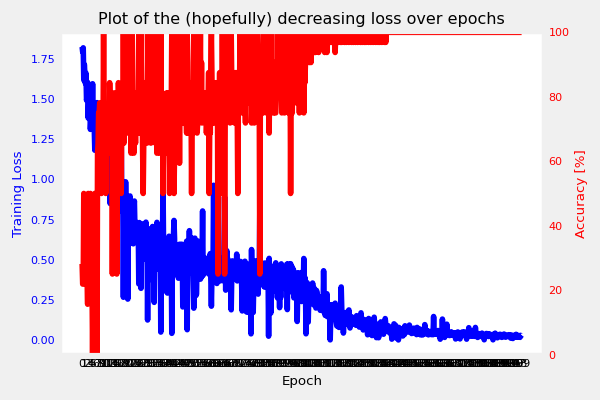

In [14]:
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot()
ax.set_title("Plot of the (hopefully) decreasing loss over epochs")
ax.plot(classifier.training_loss, 'b-')
ax.set_ylabel("Training Loss", color='b')
ax.set_xlabel("Epoch")
ax.tick_params(axis='y', labelcolor='b')
ax = ax.twinx()
ax.plot(classifier.training_accuracy, 'r-')
ax.set_ylabel("Accuracy [%]", color='r')
ax.tick_params(axis='y', labelcolor='r')
a = list(ax.axis())
a[2] = 0
a[3] = 100
ax.axis(a)
t = np.arange(0, len(classifier.training_accuracy), len(X_train)//BATCH_SIZE+1)
ax.set_xticks(ticks=t)
ax.set_xticklabels(labels=np.arange(len(t)))
fig.tight_layout()
plt.show()

With the model trained, we can see how the model has classified the training data.

*Here, I am redefining the plo_cat_mc function because it uses model.predict() method which is different for tensorflow. But in principle it does the same: it predicts labes for datapoints and returns a numpy array of labels.*

In [15]:
def plt_cat_mc(X_train, y_train, model, classes):
    #make a model for plotting routines to call
    model_predict = lambda Xl: model.predict(Xl)

    fig,ax = plt.subplots(1,1, figsize=(3,3))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    #add the original data to the decison boundary
    plt_mc_data(ax, X_train,y_train, classes, map=dkcolors_map, legend=True)
    #plot the decison boundary.
    plot_cat_decision_boundary_mc(ax, X_train, model_predict, vector=True)
    ax.set_title("model decision boundary")

    plt.xlabel(r'$x_0$');
    plt.ylabel(r"$x_1$");
    plt.show()

/content/lab_utils_multiclass_TF.py:63: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  ax.scatter(X[idx, 0], X[idx, 1],  marker=m,
/content/lab_utils_multiclass_TF.py:63: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(X[idx, 0], X[idx, 1],  marker=m,


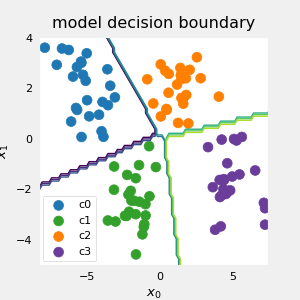

In [16]:
plt_cat_mc(X_train, y_train, classifier, classes)

Above, the decision boundaries show how the model has partitioned the input space.  This very simple model has had no trouble classifying the training data. How did it accomplish this? Let's look at the network in more detail.

Below, we will pull the trained weights from the model and use that to plot the function of each of the network units. Further down, there is a more detailed explanation of the results. You don't need to know these details to successfully use neural networks, but it may be helpful to gain more intuition about how the layers combine to solve a classification problem.

In [17]:
# gather the trained parameters from the first layer
for name, param in classifier.named_parameters():
    print(f'Layer: {name}, Size: {param.size()}, Values: {param.data}')

Layer: linear1.weight, Size: torch.Size([2, 2]), Values: tensor([[-1.0207, -0.9537],
        [ 0.4298, -3.0698]])
Layer: linear1.bias, Size: torch.Size([2]), Values: tensor([0.8971, 1.8238])
Layer: linear2.weight, Size: torch.Size([4, 2]), Values: tensor([[ 1.6321, -1.6455],
        [ 1.0024,  0.5696],
        [-2.2022, -1.2753],
        [-1.9010,  1.2514]])
Layer: linear2.bias, Size: torch.Size([4]), Values: tensor([-0.0508, -2.2247,  2.9684, -1.7919])


/content/lab_utils_multiclass_TF.py:63: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(X[idx, 0], X[idx, 1],  marker=m,
/content/lab_utils_multiclass_TF.py:63: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(X[idx, 0], X[idx, 1],  marker=m,


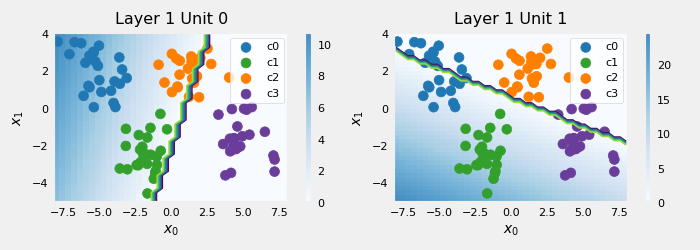

In [18]:
# plot the function of the first layer
W1, b1 = classifier.linear1.weight.data.numpy(), classifier.linear1.bias.data.numpy()
plt_layer_relu(X_train, y_train.reshape(-1,), W1, b1, classes)

/content/lab_utils_multiclass_TF.py:63: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(X[idx, 0], X[idx, 1],  marker=m,
/content/lab_utils_multiclass_TF.py:63: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(X[idx, 0], X[idx, 1],  marker=m,


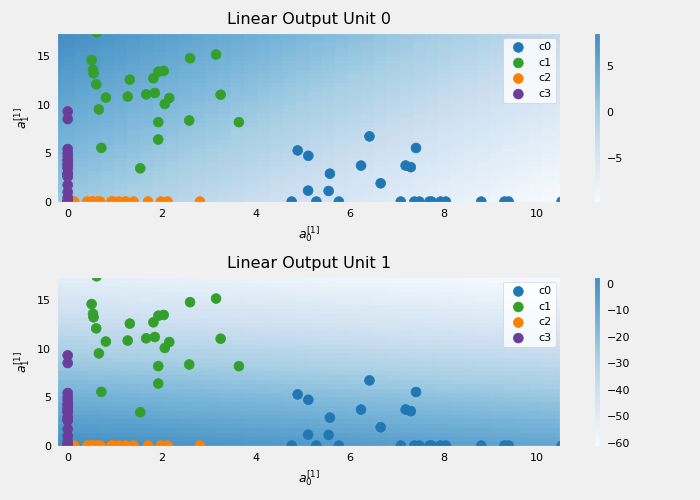

In [22]:
# gather the trained parameters from the output layer
W2, b2 = classifier.linear1.weight.data.numpy(), classifier.linear1.bias.data.numpy()
# create the 'new features', the training examples after L1 transformation
Xl2 = np.maximum(0, np.dot(X_train.numpy(), W1) + b1)

plt_output_layer_linear(Xl2, y_train.numpy().reshape(-1,), W2, b2, classes,
                        x0_rng = (-0.25,np.amax(Xl2[:,0])), x1_rng = (-0.25,np.amax(Xl2[:,1])))

***These plots don't look as they should according to the original lab. I am not gonna bugfix and transfer my layers into the expected layers by coursera functions because that's a lot of time, but my aim is to learn ML, not to bugfix. The decision boundary between classes looks the same as in the original lab, so I consider this reimplementation successful.***

## Explanation

#### Layer 1 <img align="Right" src="./images/C2_W2_mclass_layer1.png"  style=" width:600px; padding: 10px 20px ; ">
These plots show the function of Units 0 and 1 in the first layer of the network. The inputs are ($x_0,x_1$) on the axis. The output of the unit is represented by the color of the background. This is indicated by the color bar on the right of each graph. Notice that since these units are using a ReLu, the outputs do not necessarily fall between 0 and 1 and in this case are greater than 20 at their peaks.
The contour lines in this graph show the transition point between the output, $a^{[1]}_j$ being zero and non-zero. Recall the graph for a ReLu :<img align="right" src="./images/C2_W2_mclass_relu.png"  style=" width:200px; padding: 10px 20px ; "> The contour line in the graph is the inflection point in the ReLu.

Unit 0 has separated classes 0 and 1 from classes 2 and 3. Points to the left of the line (classes 0 and 1) will output zero, while points to the right will output a value greater than zero.  
Unit 1 has separated classes 0 and 2 from classes 1 and 3. Points above the line (classes 0 and 2 ) will output a zero, while points below will output a value greater than zero. Let's see how this works out in the next layer!

#### Layer 2, the output layer  <img align="Right" src="./images/C2_W2_mclass_layer2.png"  style=" width:600px; padding: 10px 20px ; ">

The dots in these graphs are the training examples translated by the first layer. One way to think of this is the first layer has created a new set of features for evaluation by the 2nd layer. The axes in these plots are the outputs of the previous layer $a^{[1]}_0$ and $a^{[1]}_1$. As predicted above, classes 0 and 1 (blue and green) have  $a^{[1]}_0 = 0$ while classes 0 and 2 (blue and orange) have $a^{[1]}_1 = 0$.  
Once again, the intensity of the background color indicates the highest values.  
Unit 0 will produce its maximum value for values near (0,0), where class 0 (blue) has been mapped.    
Unit 1 produces its highest values in the upper left corner selecting class 1 (green).  
Unit 2 targets the lower right corner where class 2 (orange) resides.  
Unit 3 produces its highest values in the upper right selecting our final class (purple).  

One other aspect that is not obvious from the graphs is that the values have been coordinated between the units. It is not sufficient for a unit to produce a maximum value for the class it is selecting for, it must also be the highest value of all the units for points in that class. This is done by the implied softmax function that is part of the loss function (`SparseCategoricalCrossEntropy`). Unlike other activation functions, the softmax works across all the outputs.

You can successfully use neural networks without knowing the details of what each unit is up to. Hopefully, this example has provided some intuition about what is happening under the hood.

## Congratulations!
You have learned to build and operate a neural network for multiclass classification.
